# Feasibility of ammonia-aqua chiller

In [3]:
%%html
<img src="../img/Diagram_for_ammonia.svg">

## Definitions

- $T_{evap}$ : temperature at evaporator outlet (point 13)
- $T_{cond}$ : temperature at condenser outlet (point 10)
- $T_{abs}$ : Temperature at absorber liquid outlet (point 1)
- $T_{gen}$ : Temperature at generator liquid outlet (point 4)
- $T_{rect}$ : Temperature at rectifier vapor outlet (point 9)
- $x_{refrig}$ : The ammonia mass fraction in the refrigerant stream (points 9, 10, 11, 12, 13, 14)
- $x_{rich}$ : The ammonia mass fraction in the rich stream (points 1, 2, 3, 3')
- $x_{weak}$ : The ammonia mass fraction in the weak stream (points 4, 5, 6)
- $Qu_{evap}$ : the vapor quality at the evaporator outlet (point 13) (typically less than 1 because there is some water in the refrigerant)

### Generator/desorber

- Assumptions are designed to give the "best case" of performance.
- Assumption: vapor produced in the desorber is everywhere locally in equilibrium with the liquid.
- Assumption: vapor flows counter to liquid, ie. from near point 4 toward point 3', so all vapor going to rectifier comes from near point 3'. This assumption affects the computation of the heat vs temperature demand curve in the desorber HX.
- Point 3 : Rich stream entering desorber, typically subcooled.
- Point 3' : The point in the rich stream where external heating brings it to saturated state (Qu=0).
- Unnamed point : The vapor stream
- Point 8 : The vapor stream leaving the desorber and entering the rectifier.
- Point 7 : The reflux (liquid) returned from the rectifier to the desorber.

### Rectifier:

- Assumptions are designed to give the best case of performance, equivalent to design with infinite number of plates and size.
- Assumption: liquid formed is everywhere locally in equilibrium with vapor, and flowing counter to it. This assumption affects the computation of the heat vs temperature demand curve.
- Vapor stream starts at point 8 and exits at point 9.
- Liquid stream starts at (unnamed point in equilibrium with point 9) and exits at point 7.

### Absorber:

- Assumption : vapor absorbed is everywhere locally in equilibrium with liquid (or absorbs into subcooled liquid with no resistance) and flowing counter to it.
- Point 1 : Liquid outlet at equilibrium with refrigerant vapor inlet (point 14).
- Assumption : Computation of the heat rejection demand vs temperature curve in the absorber stream (for HX calculations) depends on the weak stream inlet state (point 6) as follows:
  - If it is subcooled, then there is an imagined segment of the process near the weak inlet where the liquid stream absorbs refrigerant without any demand for heat rejection, until the liquid stream reaches saturation and equilibrium.
  - Saturated liquid : The vapor-liquid interface extends through the entire absorber. Absorbing an incremental amount of vapor requires an amount of heat rejection depending on the local equilibrium state and mass flow rates of liquid and vapor.
  - Partially vapor : there is an imagined segment of the absorber near the weak stream inlet where the weak stream just rejects heat via the HX and does not absorb any vapor. Throughout that process, the liquid and vapor are in equilibrium and are represented by one state with the mass fraction of the weak stream. Upon reaching a saturated liquid state, the weak stream enters the main segment of the absorber and begins to absorb from the refrigerant stream.
  - All vapor : there is clearly a problem with the design. But nevertheless, I cool the weak stream all the way to saturated liquid state, just as for partial vapor at inlet.

### Other assumptions

- For purpose of this feasibility question, neglect friction losses and resulting pressure changes.

## Constraints

There are some necessary conditions for the chiller to produce refrigerant flow. I'll try to write these as inequalities, so that we can develop constraint functions that can be used in a solver or optimizer. Drawing a cycle may be feasible for cases with equality, but to actually produce cooling and compute positive mass flow, the inequalities must hold strictly.

### Initial inputs
We assume that $Qu_{evap}$, $x_{refrig}$, $T_{evap}$, and $T_{cond}$ are given. Clearly, we must require that

* $T_{evap} \le T_{cond}$
* $T_{cond}$ less that critical temperature at x_refrig
* $T_{evap}$ greater than freezing temperature at x_refrig

Then we'll compute $P_{evap}$ and $P_{cond}$ from the other inputs.

### Absorber

This is the heart of the cooling cycle, as the absorber is the component that draws a low pressure on the evaporator. So the constraint can be viewed in terms of pressure: $P_{vapor,absorber} \le P_{evap}$ where the subscript refers to the vapor state at equilibrium with absorber rich outlet (point 1). That is,

* $P(T=T_{abs}, x=x_{rich}, Qu=0) \le P_{evap}$

In the most generous case, the refrigerant vapor would be in equilibrium with the rich liquid, so we could substitute:

* $P(T=T_{abs}, x=x_{refrig}, Qu=1) \le P_{evap}$

Since the state function is monotonic and increasing wrt. T and x inputs (decreasing wrt. Qu), we could try re-writing alternate forms:

* $x(T=T_{abs}, P=P_{evap}, Qu=1) \ge x_{refrig}$, or
* $T(P=P_{evap}, x=x_{refrig}, Qu=1) \ge T_{abs}$
* $Qu(T=T_{abs}, P=P_{evap}, x=x_{refrig}) \le 1$

### Generator

For the generator to produce vapor, we merely need it to heat the inlet stream beyond saturation. (We place no requirement on the mass fraction of the vapor coming off, since the rectifier will control what is ultimately delivered as refrigerant.) So to start, we can write the constraint:

* $ Qu(T=T_{gen}, P=P_{cond}, x=x_{rich}) \ge 0 $, with alternate forms:
  * $ x(...) \le x_{rich}$
  * $ P(...) \ge P_{cond}$
  * $ T(...) \le T_{gen}$

Although we have not previously fixed the rich stream ammonia mass fraction, $x_{rich}$, we do have a constraint on that resulting from the constraints on the absorber:

$$ x_{rich} \le x(T=T_{abs}, P=P_{evap}, Qu=0) $$

Via the transitive property, this relation together with the appropriate form of the constraint gives:

* $ x(T=T_{gen}, P=P_{cond}, Qu=0) \le x(T=T_{abs}, P=P_{evap}, Qu=0) $

The right hand side may be called $x_{rich,max}$, so all the alternate versions of this constraint are:

* $ x(T=T_{gen}, P=P_{cond}, Qu=0) \le x_{rich,max} $
* $ P(T=T_{gen}, x=x_{rich,max}, Qu=0) \ge P_{cond} $
* $ T(x=x_{rich,max}, P=P_{cond}, Qu=0) \le T_{gen} $
* $ Qu(T=T_{gen}, P=P_{cond}, x=x_{rich,max}) \ge 0 $

We should note that this new inequality is necessary to guarantee vapor formation, but since we dropped the intermediate inequality, it is worthwhile to ask whether it is sufficient. Well, as more refrigerant flows, $x_{rich}$ must drop below $x_{rich,max}$ (to be able to pick up a larger ammonia mass) and this pushes up the lower limit on $T_{gen}$. However, in the limiting case as refrigerant flow drops to zero (for fixed rich solution flow), $x_{rich}$ and $x_{weak}$ converge. Considering the supply heat demand, a goal of keeping $T_{gen}$ to a minimum favors that the ammonia solution be rich as possible. Considering the heat reject load, a goal of keeping $T_{abs}$ to a maximum favors that the ammonia solution be as weak as possible. So the absorber and desorber are in disagreement; but for a barely feasible case, we can use $x_{rich,max}$.

### Rectifier

The rectifier must cool and purify the ammonia content of the vapor stream to $x_{refrig}$. However, once having determined the condenser pressure, the final extent of the process, assuming equilibrium, could be specified by either $x_{refrig}$ or $T_{rect}$. But in the previous constraints we already assumed that $x_{refrig}$ was used to determine pressure levels, so here let's just constrain $T_{rect}$ this way:

- $x_{refrig} \le x(T=T_{rect}, P=P_{cond}, Qu = 1)$
- $T_{rect} \le T(P=P_{cond}, x=x_{refrig}, Qu = 1)$

In this case, the system can produce positive cooling even when strict equality holds, so we can justify throwing away the $T_{rect}$ as an unnecessary input.

### Visualize relations between a few variables of state

In [1]:
import CoolProp
import CoolProp.CoolProp as CP
import numpy
from numpy import array, inf, nan
import matplotlib.pyplot as plt
T0, x0, Qu0 = 350., 0.8, 1.0
P0 = CP.PropsSI('P','T',T0,'Q',Qu0,"REFPROP::ammonia[{}]&water[{}]".format(x0,1.-x0))

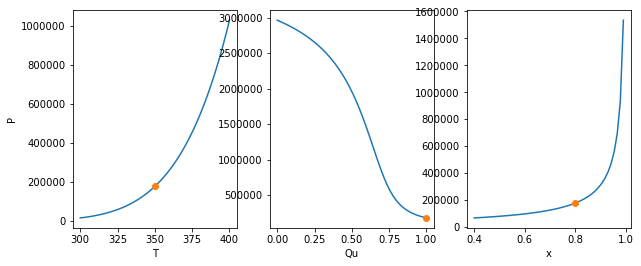

In [2]:
T = numpy.linspace(300,400)
Qu = numpy.linspace(0,1)
x = numpy.linspace(0.4,0.99)

plt.close('all')
fig = plt.figure(figsize=[10,4])

#CP.PropsSI('P','T',350, 'Q',1,"REFPROP::ammonia[0.1]&water[0.9]")
P_vs_T = CP.PropsSI('P','T',T,'Q',Qu0,"REFPROP::ammonia[{}]&water[{}]".format(x0,1.-x0))
fig.add_subplot(131)
plt.plot(T, P_vs_T)
plt.plot(T0, P0, 'o')
plt.xlabel('T')
plt.ylabel('P')

P_vs_Qu = CP.PropsSI('P','T',T0,'Q',Qu,"REFPROP::ammonia[{}]&water[{}]".format(x0,1.-x0))
fig.add_subplot(132)
plt.plot(Qu, P_vs_Qu)
plt.plot(Qu0, P0, 'o')
plt.xlabel('Qu')

P_vs_x = array([CP.PropsSI('P','T',T0,'Q',Qu0,"REFPROP::ammonia[{}]&water[{}]".format(xi,1.-xi))
                for xi in x])
fig.add_subplot(133)
plt.plot(x, P_vs_x)
plt.plot(x0, P0, 'o')
plt.xlabel('x')

plt.show()

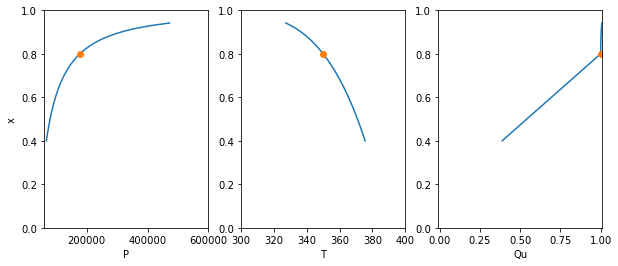

In [15]:
qt5 = False
if qt5:
    %matplotlib qt5
else:
    %matplotlib inline
plt.close('all')
fig = plt.figure(figsize=[10,4])
ax1=fig.add_subplot(131)
ax1.set_ylim(0,1)
ax1.set_xlim(6e4, 6e5)
ax1.set_ylabel('x')
ax1.set_xlabel('P')

ax2=fig.add_subplot(132)
ax2.set_ylim(0,1)
ax2.set_xlim(3e2, 4e2)
ax2.set_xlabel('T')

ax3=fig.add_subplot(133)
ax3.set_ylim(0,1)
ax3.set_xlim(-1e-2, 1+1e-2)
ax3.set_xlabel('Qu')

if qt5:
    ax1.plot(P0, x0, 'o')
    ax2.plot(T0, x0, 'o')
    ax3.plot(Qu0, x0, 'o')

pointopts = dict(color='grey', alpha=0.5, markersize=5.)

CPRP = CoolProp.AbstractState("REFPROP","ammonia&water")
PTQ = numpy.empty([3,len(x)])
PTQ.fill(nan)
try:
    for i,xi in enumerate(x):
        #print("Case", i, flush=True)
        if i > 45:
            continue
        CPRP.set_mole_fractions([xi,1-xi])
        try:
            CPRP.update(CoolProp.QT_INPUTS,Qu0,T0)
            pi = CPRP.p()
        except ValueError:
            pi = nan
            
        try:
            CPRP.update(CoolProp.PQ_INPUTS,P0,Qu0)
            ti = CPRP.T()
        except ValueError:
            ti = nan
            
        try:
            CPRP.update(CoolProp.PT_INPUTS,P0,T0)
            qi = CPRP.Q()
        except ValueError:
            qi = nan
        if qt5:
            ax1.plot(pi, xi, 'o', **pointopts)
            ax2.plot(ti, xi, 'o', **pointopts)
            ax3.plot(qi, xi, 'o', **pointopts)
            fig.canvas.draw()
            fig.canvas.flush_events()
        else:
            PTQ[:,i] = pi, ti, qi
except:
    pass

if not qt5:
    ax1.plot(PTQ[0,:], x)
    ax2.plot(PTQ[1,:], x)
    ax3.plot(PTQ[2,:], x)
    ax1.plot(P0, x0, 'o')
    ax2.plot(T0, x0, 'o')
    ax3.plot(Qu0, x0, 'o')

    plt.show()

In [4]:
PTQ

array([[  6.71149408e+04,   6.83799601e+04,   6.96941067e+04,
          7.10603106e+04,   7.24817414e+04,   7.39618337e+04,
          7.55043155e+04,   7.71132405e+04,   7.87930247e+04,
          8.05484880e+04,   8.23849023e+04,   8.43080458e+04,
          8.63242662e+04,   8.84405528e+04,   9.06646211e+04,
          9.30050103e+04,   9.54711969e+04,   9.80737293e+04,
          1.00824385e+05,   1.03736355e+05,   1.06824470e+05,
          1.10105461e+05,   1.13598279e+05,   1.17324481e+05,
          1.21308701e+05,   1.25579223e+05,   1.30168696e+05,
          1.35115017e+05,   1.40462448e+05,   1.46263030e+05,
          1.52578397e+05,   1.59482124e+05,   1.67062815e+05,
          1.75428213e+05,   1.84710751e+05,   1.95075182e+05,
          2.06729267e+05,   2.19939069e+05,   2.35051373e+05,
          2.52527498e+05,   2.72995957e+05,   2.97337675e+05,
          3.26830378e+05,   3.63407195e+05,   4.10153234e+05,
          4.72348262e+05,              nan,              nan,
        

In [57]:
# Absorber "Good case": P_evap is greater than the equilibrium P0
P_evap = P0 * 1.1
Qu_imagined = CP.PropsSI('Q','T',T0,'P',P_evap,"REFPROP::ammonia[{}]&water[{}]".format(x0,1.-x0))
Qu_imagined

0.9675526740934721

In [58]:
# Absorber "Bad case": P_evap is less than the equilibrium P0
P_evap = P0 * 0.9
Qu_imagined = CP.PropsSI('Q','T',T0,'P',P_evap,"REFPROP::ammonia[{}]&water[{}]".format(x0,1.-x0))
Qu_imagined

1.0005894260535513